# Machine Learning for Stock Trading: Natural Language Processing

**Hugh Donnelly, CFA**<br>
*AlphaWave Data*

**April 2021**

## Introduction

Pairs trading is perhaps the earliest form of relative value quantitative trading in equities. Using some modern Machine Learning tools in the pair trading investment process, we will show how to create sensible pairs without using any price data.

Certain stocks have highly related price series because they:

- operate in similar business lines
- have similar economic exposures
- have similar regulatory burdens
- have a coincident set of homogenous investors
- operate in the same geographic markets

Therefore, if we could **read about and understand** the business of each company and then link up companies based on this understanding, we should have a robust set of potential eligible pairs. This is a perfect task for Machine Learning, and, specifically, the sub-field of **Natural Language Processing.**

In this analysis, we will:

1. gather business profiles on stocks from the [AlphaWave Data Stock Analysis API](https://rapidapi.com/alphawave/api/stock-analysis/endpoints) using the [Company Description](https://rapidapi.com/alphawave/api/stock-analysis?endpoint=apiendpoint_f3feb0eb-2064-441c-a597-da681969e48f) endpoint.
2. utilize the `scikit-learn` natural language processing functionality `CountVectorizer` and `TfidfTransformer` to "read" these descriptions and extract important and novel concept features across all companies.
3. cluster stocks with `DBSCAN` to find stocks that have similar profiles.
4. visualize the features for a handful of stocks via `WordCloud` to get some intuition on what the ML model is learning.
5. inspect the time series of discovered clusters to see if this process, having no stock price series inputs at all, are related.
6. backtest a pair to determine how well our identified pairs trade algorithmically.

Jupyter Notebooks are available on [Google Colab](https://colab.research.google.com/drive/1eQsMhx-3eBlkRSnx-syRZGGCDWbtn_FD?usp=sharing) and [Github](https://github.com/AlphaWaveData/Jupyter-Notebooks/blob/master/AlphaWave%20Data%20Machine%20Learning%20for%20Stock%20Trading%20with%20Natural%20Language%20Processing%20example.ipynb).

For this project, we use several Python-based scientific computing technologies listed below.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests
import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import DBSCAN

from wordcloud import WordCloud

import pymc3 as pm

import theano as th
import seaborn as sns


## 1. Define the Stock Universe

We start by specifying that we will constrain our search for pairs to a large and liquid single stock universe. To achieve this, we create a function that scrapes the tickers of the S&P 500 and then cleans the tickers by replacing those containing a `.` with a `-` so we can easily use them in [AlphaWave Data's APIs](https://www.alphawavedata.com/).

In [2]:
# Scrape the S&P 500 tickers from Wikipedia

def get_tickers():
    wiki_page = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies').text
    sp_data = pd.read_html(wiki_page)
    ticker_df = sp_data[0]
    ticker_options = ticker_df['Symbol']
    return ticker_options

In [3]:
# Run the ticker scrape function
# Let's convert the get_tickers() output to a list and 
# replace tickers that have '.' with '-' so we can use AlphaWave Data APIs

stock_tickers = get_tickers()
stock_tickers = stock_tickers.to_list()
for ticker in range(len(stock_tickers)):
    stock_tickers[ticker] = stock_tickers[ticker].upper().replace(".", "-")

print (len(stock_tickers))
# stock_tickers

505


## 2. Gather Business Profiles

We can use the [AlphaWave Data Stock Analysis API](https://rapidapi.com/alphawave/api/stock-analysis/endpoints) to pull a company's profile from the [Company Description](https://rapidapi.com/alphawave/api/stock-analysis?endpoint=apiendpoint_f3feb0eb-2064-441c-a597-da681969e48f) endpoint.

To call this API with Python, you can choose one of the supported Python code snippets provided in the API console. The following is an example of how to invoke the API with Python Requests. You will need to insert your own <b>x-rapidapi-host</b> and <b>x-rapidapi-key</b> information in the code block below.

In [9]:
# Fetch company profile descriptions

url = "https://stock-analysis.p.rapidapi.com/api/v1/resources/profile"

headers = {
    'x-rapidapi-key': "YOUR_X-RAPIDAPI-KEY_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS",
    'x-rapidapi-host': "YOUR_X-RAPIDAPI-HOST_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS"
    }

description_data = []

for ticker in stock_tickers:
    
    querystring = {"ticker":ticker}
        
    try:
        key_stats_response = requests.request("GET", url, headers=headers, params=querystring)
        df = pd.DataFrame({'profile': key_stats_response.text},
                          index=[ticker])
        description_data.append(df)
    except:
        pass

profiles_df = pd.concat(description_data, ignore_index=False)
profiles_df

profile
MMM   "'3M Company develops, manufactures, and marke...
ABT   "\"Abbott Laboratories discovers, develops, ma...
ABBV  "\"AbbVie Inc. discovers, develops, manufactur...
ABMD  "'Abiomed, Inc. engages in the research, devel...
ACN   "'Accenture plc, a professional services compa...
...                                                 ...
YUM   "'YUM! Brands, Inc., together with its subsidi...
ZBRA  "'Zebra Technologies Corporation, together wit...
ZBH   "\"Zimmer Biomet Holdings, Inc., together with...
ZION  "'Zions Bancorporation, National Association p...
ZTS   "'Zoetis Inc. discovers, develops, manufacture...

[505 rows x 1 columns]

In [36]:
# Remove profiles with missing text

missing_text = '""'

profiles_df = profiles_df.loc[~(profiles_df['profile'] == missing_text)]

In [37]:
print ("We have %d stocks in the universe with profiles." % len(profiles_df))

We have 504 stocks in the universe with profiles.


## 3. Build Machine Learning Pipeline to Read the Profiles

Natural Language Processing (NLP) itself has a lot of sub-fields: named entity recognition, natural language understanding, machine translation, sentiment analysis, etc. For our purposes, we are interested in document clustering because we have many stock profiles and we want to group together those which are very similar.

We will use `scikit-learn` classes: [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and [`TfidfTransformer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to "read" the profiles.  This is the so called *bag of words* approach:

- Tokenize the text: break up the text into countable segments called *ngrams*.
- Count all the occurences of the tokens.
- Normalize the counts.

### 3.a Count Vectorizer
We give the `CountVectorizer` a block of text, and we get back a word count matrix with individual words on the column axis and each document along the row axis. It doesn't actually count words. Instead, it counts *ngrams*. An *ngram* is a text fragment. For this analysis, we use complete words but also bigrams and trigrams  (which are sequences of two words and three words respectively).

Let's see what `CountVectorizer` does on two "documents" to extract words and bigrams:

In [46]:
text = [
    "AlphaWave Data creates APIs that supply financial information which lowers the barriers for talented people everywhere to write investment algorithms.",
    "Some algorithms will be highlighted in blog posts."
]

In [47]:
vectorizer = CountVectorizer(
    analyzer='word',    # a single ngram is a "word": characters seperated by spaces
    ngram_range=(1,2)   # we care about ngrams with min length 1 and max length 2
)

In [48]:
# Transform the text
count_mat = vectorizer.fit_transform(text)

In [49]:
# Let's see the counts and all the ngrams across each document
list(zip(count_mat.toarray()[0], count_mat.toarray()[1], vectorizer.get_feature_names()))

[(1, 1, 'algorithms'),
 (0, 1, 'algorithms will'),
 (1, 0, 'alphawave'),
 (1, 0, 'alphawave data'),
 (1, 0, 'apis'),
 (1, 0, 'apis that'),
 (1, 0, 'barriers'),
 (1, 0, 'barriers for'),
 (0, 1, 'be'),
 (0, 1, 'be highlighted'),
 (0, 1, 'blog'),
 (0, 1, 'blog posts'),
 (1, 0, 'creates'),
 (1, 0, 'creates apis'),
 (1, 0, 'data'),
 (1, 0, 'data creates'),
 (1, 0, 'everywhere'),
 (1, 0, 'everywhere to'),
 (1, 0, 'financial'),
 (1, 0, 'financial information'),
 (1, 0, 'for'),
 (1, 0, 'for talented'),
 (0, 1, 'highlighted'),
 (0, 1, 'highlighted in'),
 (0, 1, 'in'),
 (0, 1, 'in blog'),
 (1, 0, 'information'),
 (1, 0, 'information which'),
 (1, 0, 'investment'),
 (1, 0, 'investment algorithms'),
 (1, 0, 'lowers'),
 (1, 0, 'lowers the'),
 (1, 0, 'people'),
 (1, 0, 'people everywhere'),
 (0, 1, 'posts'),
 (0, 1, 'some'),
 (0, 1, 'some algorithms'),
 (1, 0, 'supply'),
 (1, 0, 'supply financial'),
 (1, 0, 'talented'),
 (1, 0, 'talented people'),
 (1, 0, 'that'),
 (1, 0, 'that supply'),
 (1, 0, 'th

Generally we don't care about "common" words like "the", "a", "and", "on", etc. These words are not going to indicate anything novel in the corpus. The term for these words in NLP is *stop words*. `scikit-learn` contains a bunch of built-in stop words that we can use.

In [50]:
vectorizer = CountVectorizer(
    analyzer='word',    # a single ngram is a "word": characters separated by spaces
    ngram_range=(1,2),  # we care about ngrams with min lentgh 1 and max length 2
    stop_words='english'
)

In [51]:
# Transform the text
count_mat = vectorizer.fit_transform(text)

In [52]:
# Let's see the counts and all the ngrams across each document
list(zip(count_mat.toarray()[0], count_mat.toarray()[1], vectorizer.get_feature_names()))

[(1, 1, 'algorithms'),
 (0, 1, 'algorithms highlighted'),
 (1, 0, 'alphawave'),
 (1, 0, 'alphawave data'),
 (1, 0, 'apis'),
 (1, 0, 'apis supply'),
 (1, 0, 'barriers'),
 (1, 0, 'barriers talented'),
 (0, 1, 'blog'),
 (0, 1, 'blog posts'),
 (1, 0, 'creates'),
 (1, 0, 'creates apis'),
 (1, 0, 'data'),
 (1, 0, 'data creates'),
 (1, 0, 'financial'),
 (1, 0, 'financial information'),
 (0, 1, 'highlighted'),
 (0, 1, 'highlighted blog'),
 (1, 0, 'information'),
 (1, 0, 'information lowers'),
 (1, 0, 'investment'),
 (1, 0, 'investment algorithms'),
 (1, 0, 'lowers'),
 (1, 0, 'lowers barriers'),
 (1, 0, 'people'),
 (1, 0, 'people write'),
 (0, 1, 'posts'),
 (1, 0, 'supply'),
 (1, 0, 'supply financial'),
 (1, 0, 'talented'),
 (1, 0, 'talented people'),
 (1, 0, 'write'),
 (1, 0, 'write investment')]

That looks better. Now we have extracted the words and bigrams which are significant in the corpus. The only token which appears more than once in this corpus is "algorithms". Algorithms must be important to AlphaWave Data.

Now let's run it on the company profiles.

In [55]:
# extract stop words so we can append our own
vect = CountVectorizer(stop_words='english')
stop_words = list(vect.get_stop_words())

# I am adding stop words which I do not expect to uniquely help determine stock similarity
# there are probably more to add
stop_words.extend(['founded', 'firm', 'company', 'llc', 'inc', 'incorporated'])

In [56]:
vect = CountVectorizer(
    analyzer='word',
    ngram_range=(1,3),
    strip_accents='unicode',
    max_features=3000,       # we limit the generation of tokens to the top 3000
    stop_words=stop_words
)

In [57]:
X = vect.fit_transform(profiles_df['profile'])
X

<504x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 45926 stored elements in Compressed Sparse Row format>

In [58]:
# let's see some features extracted
vect.get_feature_names()[1000:1030]

['families',
 'family',
 'farm',
 'fashion',
 'fasteners',
 'february',
 'federal',
 'feed',
 'feed ingredients',
 'feet',
 'feminine',
 'fi',
 'fiber',
 'fibers',
 'fidelity',
 'fiduciary',
 'field',
 'fields',
 'file',
 'file tmp',
 'file tmp supply',
 'film',
 'filmed',
 'filmed entertainment',
 'films',
 'filters',
 'filtration',
 'finance',
 'financial',
 'financial corporation']

### 3.b Normalization with TF-IDF
The count frequency itself isn't likely to be enough to find pairs. Why? In document classification, words that appear frequently across *all* documents are probably not meaningful. For example, in our case, it is likely that the word "headquartered" appears frequently. Let's see.

In [59]:
test_word = 'headquartered'
occurences = sum(X[:, vect.get_feature_names().index(test_word)].toarray().flatten()>0)
total = X.shape[0]
print ('%d of %d profiles contain the token "%s"!' % (occurences, total, test_word))

388 of 504 profiles contain the token "headquartered"!


(array([116.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 388.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

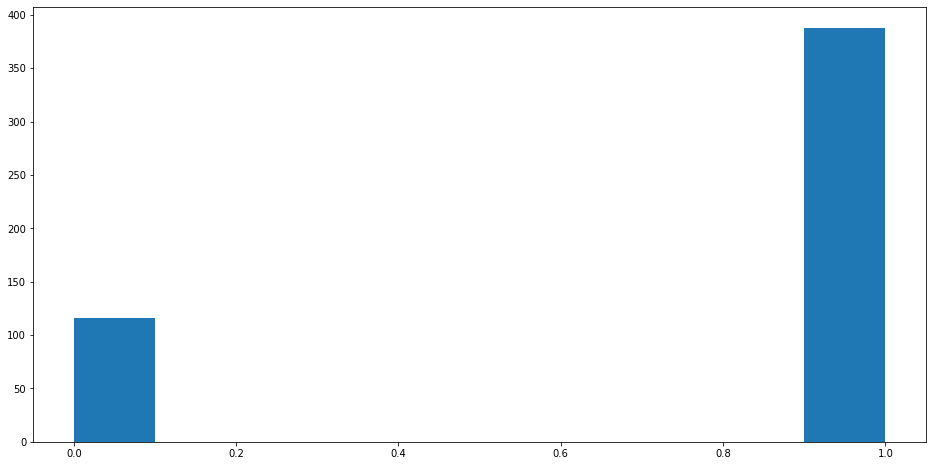

In [60]:
plt.figure(figsize=(16, 8))
plt.hist(X[:, vect.get_feature_names().index(test_word)].todense())

The word "headquartered" is in many profiles. Clearly this is not going to be a good word to cluster against. Enter **TF-IDF**, which stands for "Term-Frequency times Inverse Document-Frequency".

Using the `TfidTransformer`, the *individual token count frequency per document* (the "Term Frequency") is multiplied by a weighting
$$log \frac{1+n}{1+df(t)}+1$$
where $n$ is the total number of documents and $df(t)$ is the number of documents which contains the term $t$.

In [61]:
np.log(1+total)/(1+occurences)+1

1.0160014355508364

Hmmmmm. So multiplying by ~1.0 doesn't make a difference, but the key is that *all* tokens are multiplied by this function. This overweights infrequently occurring tokens *across* documents. The idea is that words which infrequently occur across *all documents* are signposts of novelty for the documents within which they do occur. We can see the impact of this function as:

Text(0, 0.5, 'Each term t in each document gets multipled by this')

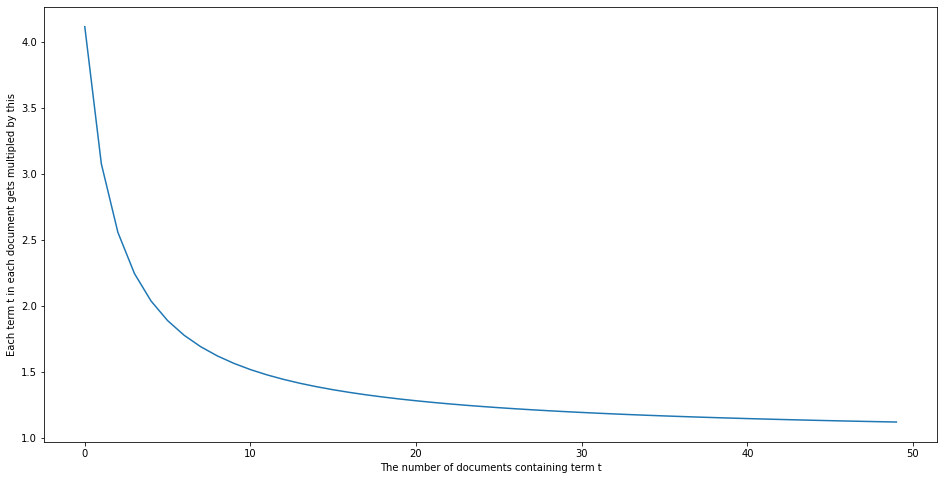

In [62]:
plt.figure(figsize=(16, 8))
plt.plot((np.log(1+total)/(1+np.linspace(1,50))) + 1)
plt.xlabel("The number of documents containing term t")
plt.ylabel("Each term t in each document gets multipled by this")

This should not be confused with scaling based on the counts *within* documents. That feature is controlled by the flag `sublinear_tf`. If this flag is `true` then each count *within* a document is scaled by $1+log(c)$, where $c$ is the count within the document. For example, if one profile said "...Energy company...energy markets...energy demand", the count of "energy" would be scaled up in that profile. We don't use this scaling in this case.

One might ask, if this word is meaningless, why not just add it to the stop words? We don't want to do that because, although "headquartered" alone is not meaningful, *maybe* the phrase "headquartered in New York" *is* meaningful.

In [63]:
test_word = 'headquartered new york'  # "in" is a stop word, so we ignore it
occurences = sum(X[:, vect.get_feature_names().index(test_word)].toarray().ravel()>0)
total = X.shape[0]
print ('%d of %d profiles contain the token "%s"!' % (occurences, total, test_word))

30 of 504 profiles contain the token "headquartered new york"!


In [64]:
# transform the count matrix
tfidf = TfidfTransformer()
X_idf = tfidf.fit_transform(X)
X_idf

<504x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 45926 stored elements in Compressed Sparse Row format>

## 4. Cluster Stocks Based on the TF-IDF Matrix
We will use the [`DBSCAN` clustering algorithm](http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#dbscan). This is an ideal algorithm to cluster pairs because:

- we don't need to specify the number of clusters.
- it does *not* cluster all stocks. This feature is important because we would not expect *all* stocks to have a closely related sibling.

After `DBSCAN` we do a second pass to only include clusters that have two stocks; i.e., we only take clusters that are tight enough to have just two stocks.

In [65]:
clf = DBSCAN(eps=1.05, min_samples=2)
labels = clf.fit_predict(X_idf)

In [66]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print ("\nTotal custers discovered: %d" % n_clusters_)

clustered = labels


Total custers discovered: 41


In [67]:
clustered_series = pd.Series(index=profiles_df.index, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

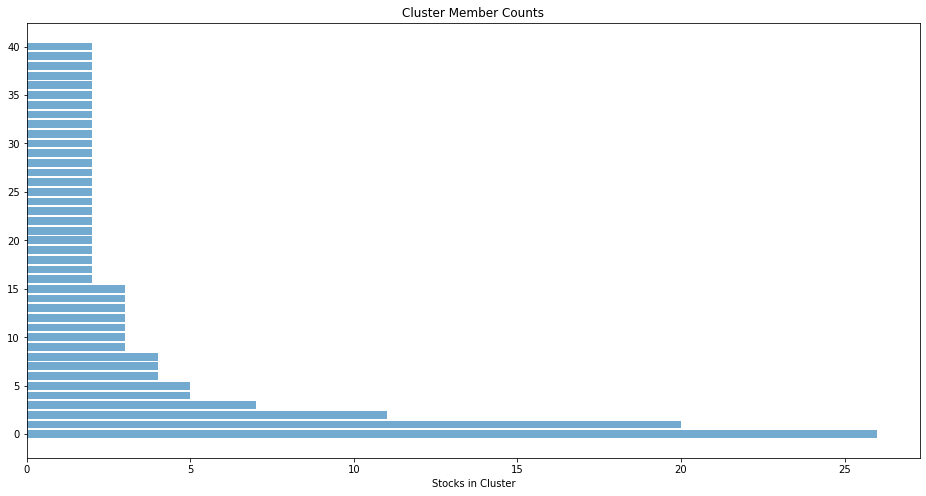

In [68]:
plt.figure(figsize=(16, 8))
plt.barh(
    range(len(clustered_series.value_counts())),
    clustered_series.value_counts(),
    alpha=0.625
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster');

In [69]:
pair_clusters = clustered_series.value_counts()[clustered_series.value_counts()<3].index.values

In [70]:
print (pair_clusters)
print ("\nTotal pair clusters discovered: %d" % len(pair_clusters))

[ 6 11 12  5  2 17 40 39 21 38 37 36 35 34 32 31 30 29 28 27 26 25 24 23
 20]

Total pair clusters discovered: 25


Let's look at the profile descriptions of a pair that we discovered.

In [71]:
cluster = clustered_series['CDNS']

profiles_df.iloc[clustered==cluster]

profile
CDNS  "\"Cadence Design Systems, Inc. provides softw...
SNPS  "\"Synopsys, Inc. provides electronic design a...

In [72]:
print (profiles_df.iloc[clustered==cluster].iloc[0,0])

"\"Cadence Design Systems, Inc. provides software, hardware, services, and reusable integrated circuit (IC) design blocks worldwide. The company offers functional verification services, including emulation and prototyping hardware. Its functional verification offering consists of JasperGold, a formal verification platform; Xcelium, a parallel logic simulation platform; Palladium, an enterprise emulation platform; and Protium, a prototyping platform for chip verification. The company also provides digital IC design products, including Genus logic synthesis and RTL power solutions, as well as Modus software solution to reduce systems-on-chip design-for-test time; physical implementation tools, including place and route, optimization, and multiple patterning preparation; and signoff products to signoff the design as ready for manufacture by a silicon foundry. In addition, it offers custom IC design and simulation products to create schematic and physical representations of circuits down t

In [33]:
print (profiles_df.iloc[clustered==cluster].iloc[1,0])

"Synopsys, Inc. provides electronic design automation software products used to design and test integrated circuits. It offers Fusion Design Platform, a digital design implementation solution; Verification Continuum Platform that provides virtual prototyping, static and formal verification, simulation, emulation, field programmable gate array (FPGA)-based prototyping, and debug solutions; and FPGA design products that are programmed to perform specific functions. The company also provides intellectual property (IP) solutions for USB, PCI Express, DDR, Ethernet, SATA, MIPI, HDMI, and Bluetooth low energy applications; analog IP, including data converters and audio codecs; and system-on-chip (SoC) infrastructure IP, datapath and building block IP, and verification IP products, as well as mathematical and floating point components, and Arm AMBA interconnect fabric and peripherals. In addition, it offers logic libraries and embedded memories; configurable processor cores and application-sp

## 5. Visualize What the ML Model Learned

We can use the [2 Year Historical Daily Prices](https://rapidapi.com/alphawave/api/stock-prices2?endpoint=apiendpoint_33fa1878-1727-4775-beeb-f6b0da5314fd) endpoint from the [AlphaWave Data Stock Prices API](https://rapidapi.com/alphawave/api/stock-prices2/endpoints) to pull in the two year historical prices.

To call this API with Python, you can choose one of the supported Python code snippets provided in the API console. The following is an example of how to invoke the API with Python Requests. You will need to insert your own <b>x-rapidapi-host</b> and <b>x-rapidapi-key</b> information in the code block below.

In [73]:
#fetch 2 year daily return data

url = "https://stock-prices2.p.rapidapi.com/api/v1/resources/stock-prices/2y"

headers = {
    'x-rapidapi-host': "YOUR_X-RAPIDAPI-HOST_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS",
    'x-rapidapi-key': "YOUR_X-RAPIDAPI-KEY_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS"
    }

stock_frames = []

for ticker in stock_tickers:
    querystring = {"ticker":ticker}
    stock_daily_price_response = requests.request("GET", url, headers=headers, params=querystring)

    # Create Stock Prices DataFrame
    stock_daily_price_df = pd.DataFrame.from_dict(stock_daily_price_response.json())
    stock_daily_price_df = stock_daily_price_df.transpose()
    stock_daily_price_df = stock_daily_price_df.rename(columns={'Close':ticker})
    stock_daily_price_df = stock_daily_price_df[{ticker}]
    stock_frames.append(stock_daily_price_df)

combined_stock_price_df = pd.concat(stock_frames, axis=1, sort=True)
combined_stock_price_df = combined_stock_price_df.dropna(how='all')
combined_stock_price_df = combined_stock_price_df.fillna("")
combined_stock_price_df

MMM         ABT        ABBV        ABMD         ACN  \
2019-04-29  177.170822   75.875763   72.136856  274.000000  176.433182   
2019-04-30  176.518814   77.126305   71.319366  277.410004  177.854675   
2019-05-01  173.314636   76.331390   70.870193  277.070007  176.530518   
2019-05-02  172.085114   76.370163   70.492889  264.769989  174.661133   
2019-05-03  172.522873   76.282928   70.708488  271.750000  172.314682   
...                ...         ...         ...         ...         ...   
2021-04-22  200.899994  123.500000  110.050003  343.399994  290.160004   
2021-04-23  202.199997  123.309998  111.379997  351.029999  291.739990   
2021-04-26  199.630005  122.580002  111.389999  348.200012  289.519989   
2021-04-27  194.449997  121.699997  111.440002  340.630005  290.250000   
2021-04-28  195.929993  121.449997  111.930000  351.170013  290.269989   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
2019-04-29  47.852070  286.140015  27.690001  165.076157  16.146397  ...   
2019-04-30  47.664215  289.250000  27.629999  164.630768  16.181368  ...   
2019-05-01  48.010258  283.350006  26.809999  162.166031  15.973430  ...   
2019-05-02  48.989048  279.640015  28.290001  165.086060  16.115202  ...   
2019-05-03  46.616219  285.579987  28.219999  161.611694  16.001785  ...   
...               ...         ...        ...         ...        ...  ...   
2021-04-22  93.699997  507.290009  79.059998  200.300003  28.320000  ...   
2021-04-23  93.019997  515.840027  82.760002  199.750000  28.299999  ...   
2021-04-26  94.239998  515.700012  85.410004  197.139999  28.209999  ...   
2021-04-27  91.599998  517.320007  85.209999  197.279999  27.799999  ...   
2021-04-28  91.250000  515.479980  84.019997  197.630005  27.969999  ...   

                  WLTW        WYNN        XEL        XLNX         XYL  \
2019-04-29  176.627579  143.701981  52.583630  114.096809   81.727402   
2019-04-30  179.371536  139.529129  53.579346  117.078827   81.317879   
2019-05-01  170.643311  141.161575  53.010361  113.668007   81.210625   
2019-05-02  173.688934  140.601318  53.029331  115.870430   77.554253   
2019-05-03  174.924728  142.340012  53.655212  115.987366   80.235596   
...                ...         ...        ...         ...         ...   
2021-04-22  233.149994  124.379997  71.120003  123.080002  109.080002   
2021-04-23  232.889999  124.150002  71.080002  129.660004  110.480003   
2021-04-26  231.300003  125.000000  70.599998  133.960007  110.440002   
2021-04-27  236.250000  127.750000  70.000000  133.610001  111.360001   
2021-04-28  245.880005  130.270004  69.809998  131.520004  111.260002   

                   YUM        ZBRA         ZBH       ZION         ZTS  
2019-04-29  100.136955  226.910004  119.042313  46.299034  100.104774  
2019-04-30  100.706123  211.139999  121.337830  46.214718  100.678154  
2019-05-01   98.342590  205.119995  119.426537  45.512085  100.628731  
2019-05-02   98.149635  205.940002  121.387100  46.355244  101.973213  
2019-05-03   99.095055  206.460007  122.470810  46.889248  102.566360  
...                ...         ...         ...        ...         ...  
2021-04-22  117.820000  487.350006  177.380005  52.560001  169.070007  
2021-04-23  117.720001  497.410004  177.619995  54.270000  170.539993  
2021-04-26  115.680000  498.500000  175.720001  54.610001  169.800003  
2021-04-27  116.410004  501.750000  176.350006  55.150002  169.750000  
2021-04-28  117.570000  496.600006  178.500000  55.250000  171.720001  

[505 rows x 505 columns]

In [77]:
symbols=list(profiles_df[clustered==cluster].index)
combined_stock_price_df[symbols]

CDNS        SNPS
2019-04-29   68.180000  119.860001
2019-04-30   69.379997  121.080002
2019-05-01   68.540001  120.089996
2019-05-02   69.449997  120.699997
2019-05-03   70.269997  121.650002
...                ...         ...
2021-04-22  140.059998  248.210007
2021-04-23  142.080002  251.449997
2021-04-26  144.229996  256.880005
2021-04-27  132.750000  251.699997
2021-04-28  133.270004  251.369995

[505 rows x 2 columns]

In [78]:
def plot_cluster(which_cluster, plot_mean=False):
    
    symbols=list(profiles_df[clustered==which_cluster].index)
    
    pricing = combined_stock_price_df[symbols]
    
    means = np.log(pricing).mean()
    data = np.log(pricing).sub(means)
    
    if plot_mean:
        means = data.mean(axis=1).rolling(window=21).mean().shift(1)
        data.sub(means, axis=0).plot()
        plt.axhline(0, lw=3, ls='--', label='mean', color='k')
        plt.legend(loc=0)
    else:
        data.plot()
        
    fig = plt.figure(1)
    fig.set_figheight(8)
    fig.set_figwidth(16)


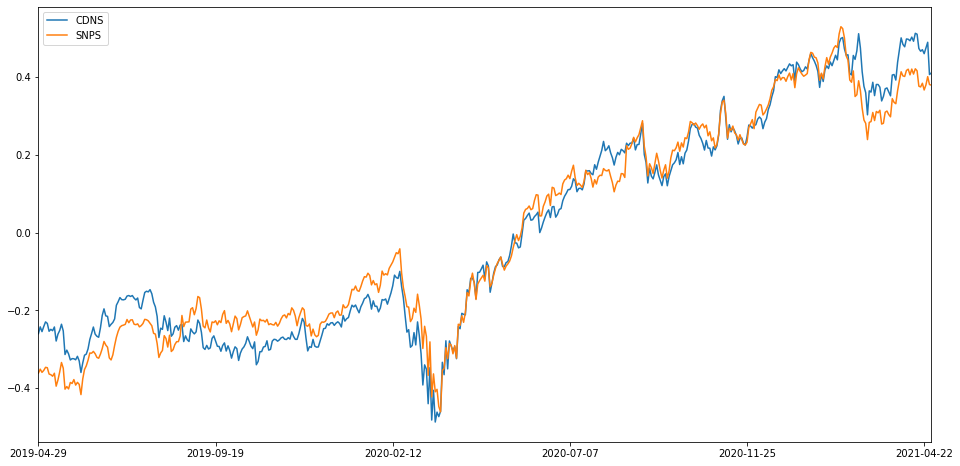

In [79]:
plot_cluster(cluster)

That's pretty amazing! Just by looking a text description of companies:
1. the ML model was able to find related companies.
2. related companies do indeed seem to have related price series.

To see what the ML model is learning, let's generate some word clouds using the code below.

In [80]:
def visualize_cluster(target_cluster):
    
    num_stocks = len(list(profiles_df[clustered==cluster].index)[:])
    num_cols = 2
    num_rows = num_stocks // num_cols 
    num_rows += num_stocks % num_cols
    position = range(1,num_stocks + 1)

    fig = plt.figure(1)
    fig.set_figheight(10)
    fig.set_figwidth(16)

    for index in range(len(list(profiles_df[clustered==cluster].index)[:])):
        
        wordcloud_ticker = list(profiles_df[clustered==cluster].index)[index]

        wordcloud_profile = [profiles_df.iloc[clustered==cluster]['profile'][index]]
        wordcloud_X = vect.fit_transform(wordcloud_profile)
        wordcloud_word_features = list(zip(wordcloud_X.toarray()[0], vect.get_feature_names()))

        wordcloud_frequencies = []
        for word in wordcloud_word_features[:]:
            if word[0] > 0:
                new_word = (word[1],word[0])
                wordcloud_frequencies.append(new_word)


        wordcloud = WordCloud(background_color="white",max_font_size=48).generate_from_frequencies(dict(wordcloud_frequencies))

        ax = fig.add_subplot(num_rows, num_cols, position[index])

        plt.tight_layout(h_pad=5, w_pad=5)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(wordcloud_ticker)
        plt.axis("off")

    plt.show()

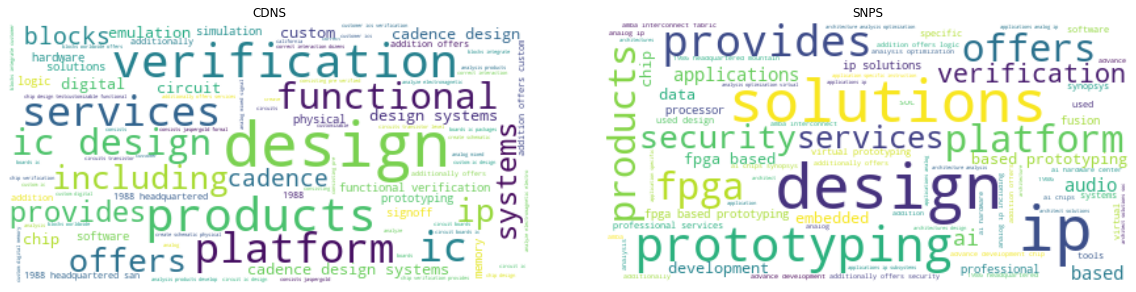

In [81]:
visualize_cluster(cluster)

The world cloud shows the text features that the ML model thinks are important. The size of a feature indicates the importance of that feature as returned by the `TfidfTransformer` across all stocks.

### 5.a Four Other Examples
Let's see a sample of others which look to have very strong pair relationships as well.

In [82]:
# Let's look at the clusters generated

clustered_series_df = clustered_series.to_frame()
clustered_series_df.columns =['cluster']
clustered_series_df['labels'] = clustered_series_df.groupby(by=['cluster']).cumcount()
clustered_series_df.reset_index(inplace=True)
clustered_series_df.groupby('cluster')['index'].apply(list)

cluster
0                         [ABBV, AMGN, BIIB, BMY, GILD]
1                                      [AAP, AZO, ORLY]
2                                            [APD, LIN]
3                                    [ALXN, INCY, VRTX]
4     [LNT, AEE, ATO, COG, CNP, CVX, FANG, DTE, DUK,...
5                                         [GOOGL, GOOG]
6                                            [AEP, ETR]
7     [AIG, CB, CINF, RE, LNC, MET, PFG, PGR, PRU, T...
8     [AMP, BAC, BK, C, CFG, CMA, FITB, FRC, GS, JPM...
9                                       [ABC, CAH, MCK]
10                  [ANTM, CNC, CI, CVS, HUM, UNH, WBA]
11                                           [AOS, PNR]
12                                          [ADP, PAYX]
13                                      [AVB, ESS, MAA]
14                                 [BKR, HAL, NOV, SLB]
15                                [BLK, BEN, IVZ, TROW]
16                             [BA, LHX, LMT, NOC, RTX]
17                                      

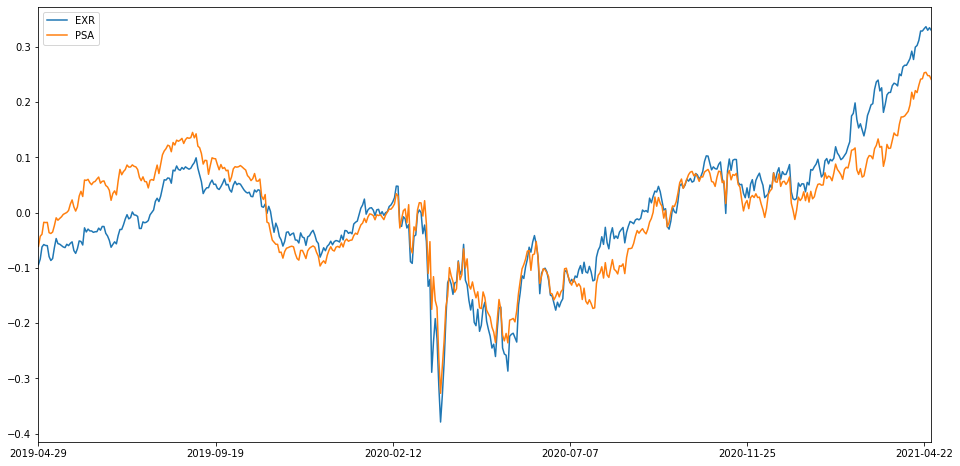

In [83]:
cluster = clustered_series['EXR']
plot_cluster(cluster)

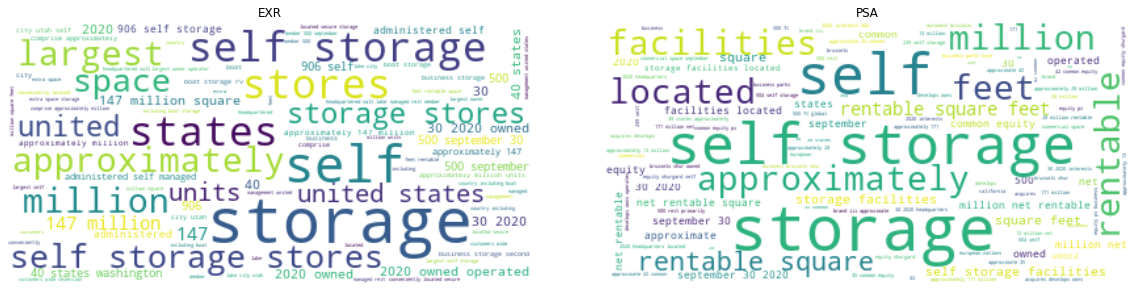

In [84]:
visualize_cluster(cluster)

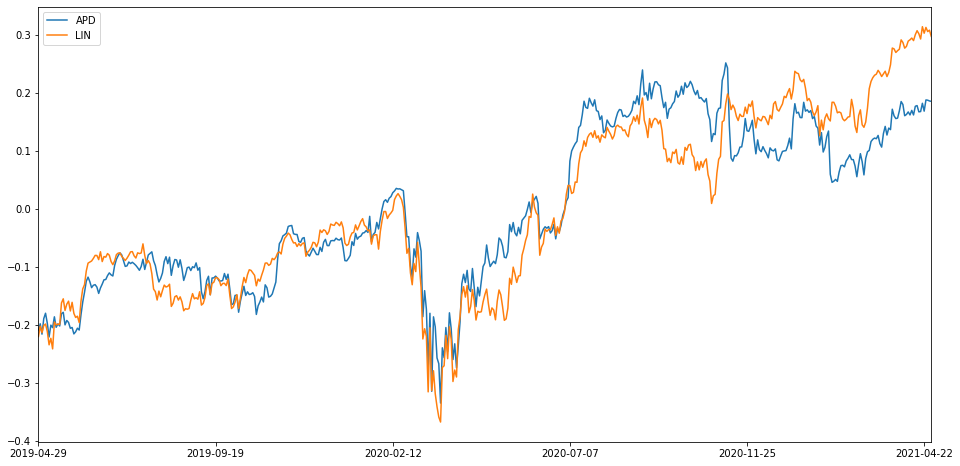

In [85]:
cluster = clustered_series['APD']
plot_cluster(cluster)

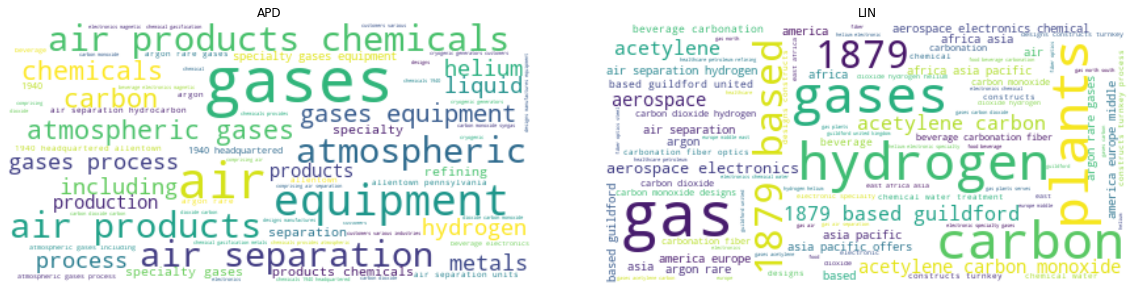

In [86]:
visualize_cluster(cluster)

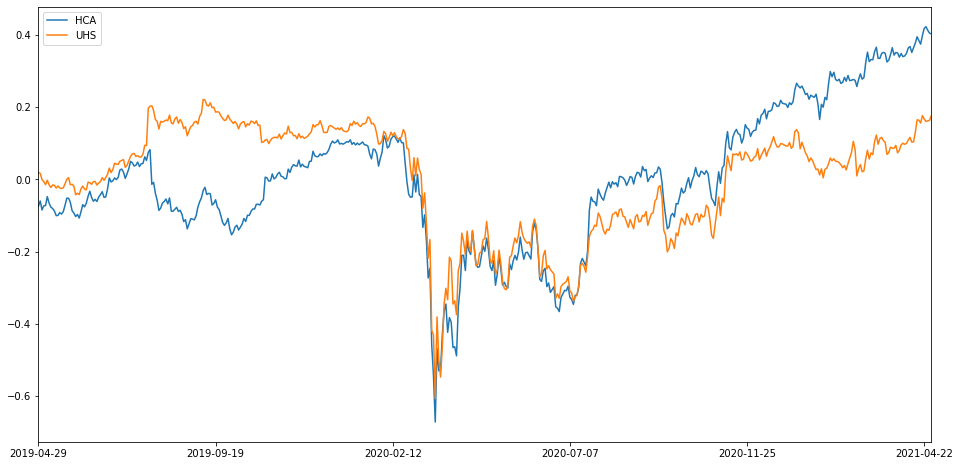

In [87]:
cluster = clustered_series['HCA']
plot_cluster(cluster)

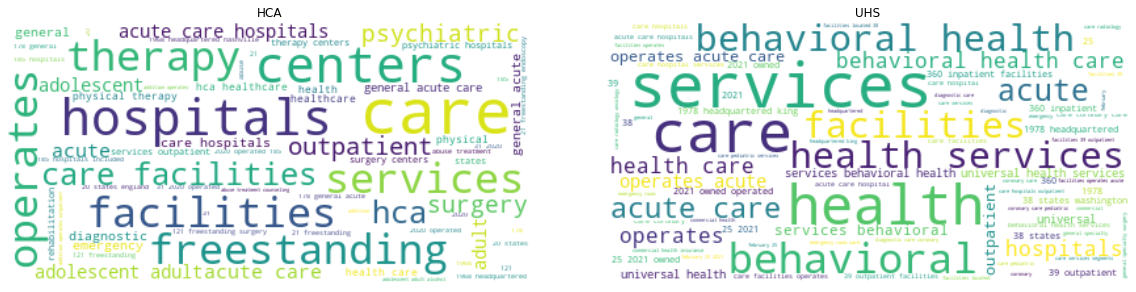

In [88]:
visualize_cluster(cluster)

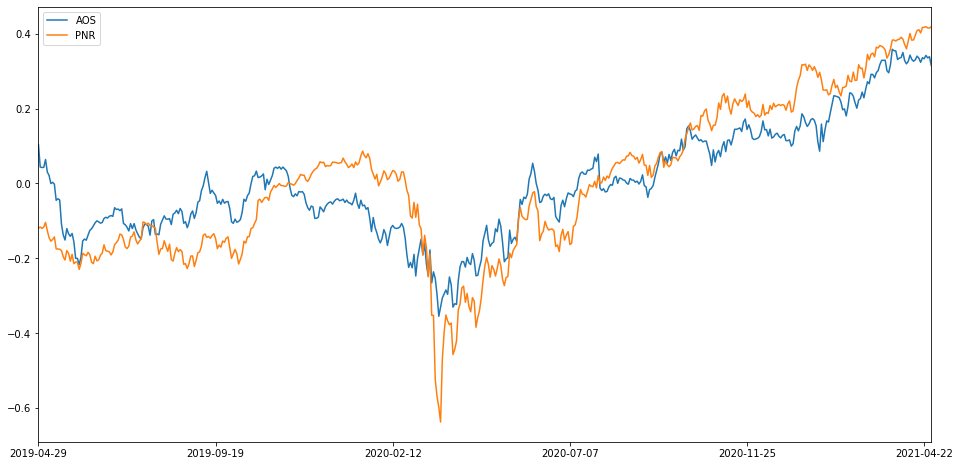

In [89]:
cluster = clustered_series['AOS']
plot_cluster(cluster)

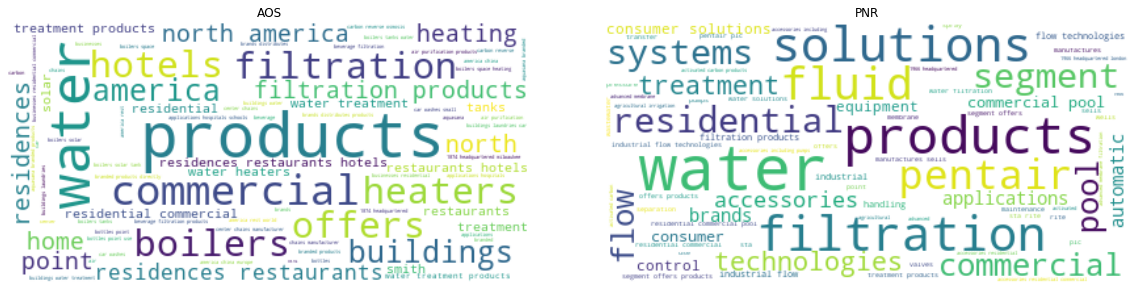

In [90]:
visualize_cluster(cluster)

### 5.b Larger Clusters

Above we only looked at clusters of size 2, but what about larger clusters? They could be co-integrated too. In fact, identifying larger number of stocks that are co-integrated allows us to extend the idea of pairs-trading. Rather than assuming that the price of two stocks will converge again after some time, we can instead assume that the price of any stock in the cluster will converge back to the rolling mean price of the whole cluster.

In [91]:
def plot_cluster_relative_to_mean(which_cluster):
    
    symbols=list(profiles_df[clustered==which_cluster].index)
    
    pricing = combined_stock_price_df[symbols]
    
    means = np.log(pricing).mean()
    data = np.log(pricing).sub(means)
    
    means = data.mean(axis=1).rolling(window=21).mean().shift(1) # shift to avoid look-ahead bias
    data.sub(means, axis=0).plot()
    plt.axhline(0, lw=3, ls='--', label='mean', color='k')
    plt.ylabel('Price divergence from group mean')
    plt.legend(loc=0)
    
    fig = plt.figure(1)
    fig.set_figheight(8)
    fig.set_figwidth(16)

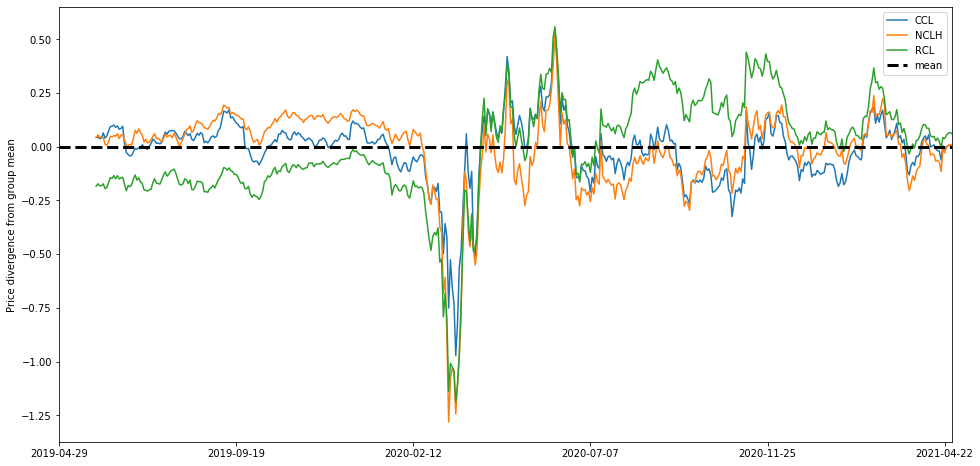

In [92]:
cluster = clustered_series['CCL']
plot_cluster_relative_to_mean(cluster)

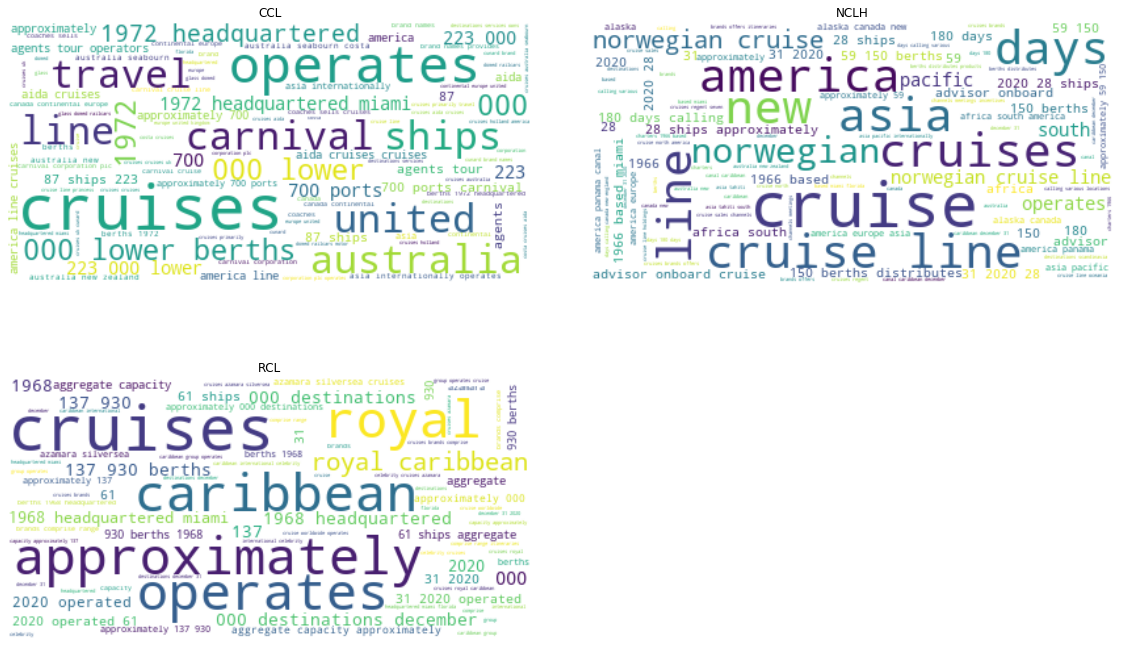

In [93]:
visualize_cluster(cluster)

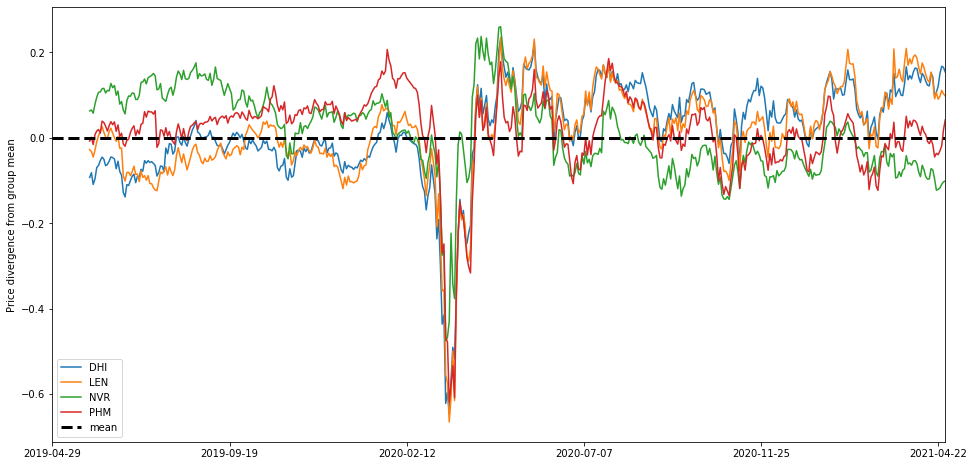

In [94]:
cluster = clustered_series['DHI']
plot_cluster_relative_to_mean(cluster)

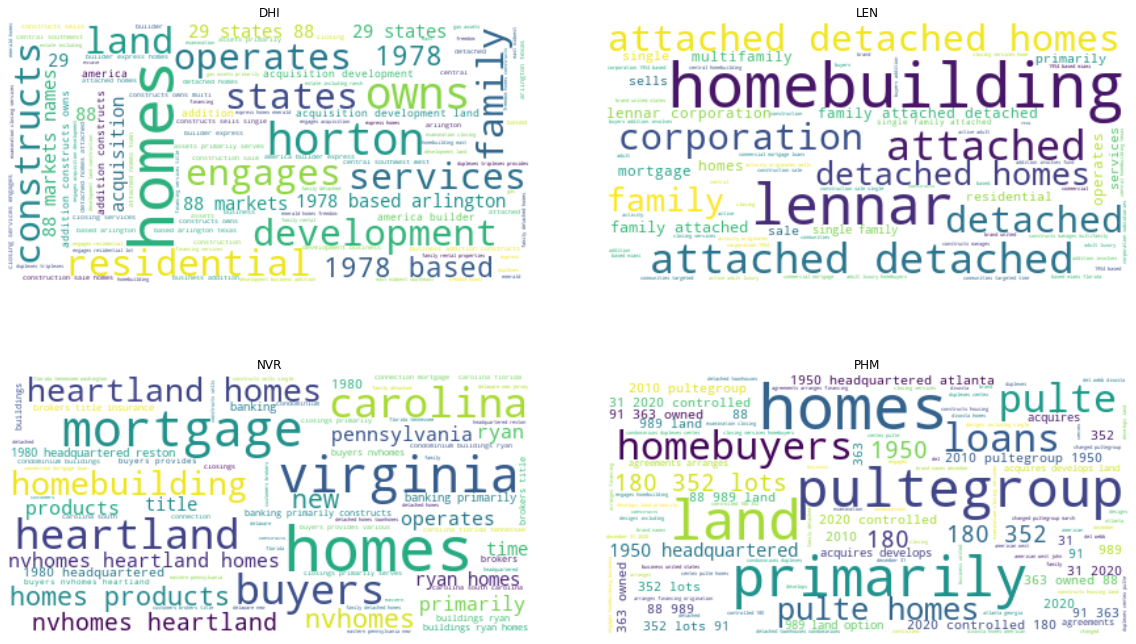

In [95]:
visualize_cluster(cluster)

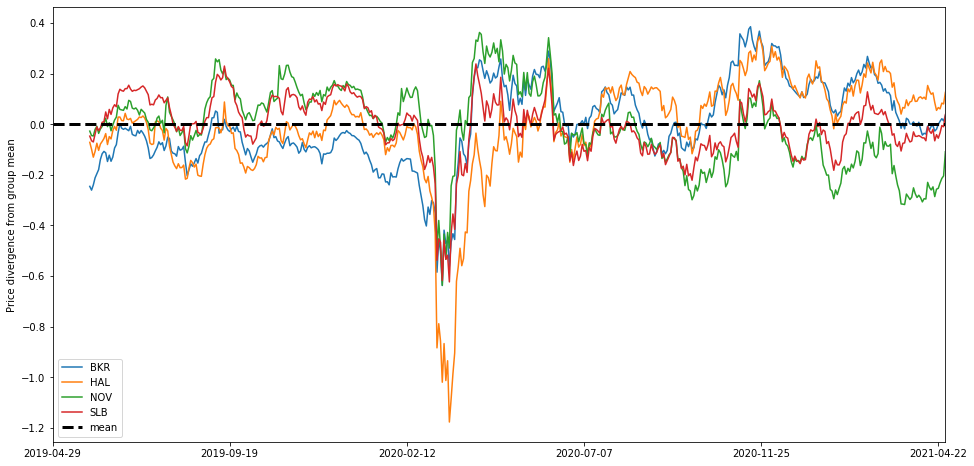

In [96]:
cluster = clustered_series['BKR']
plot_cluster_relative_to_mean(cluster)

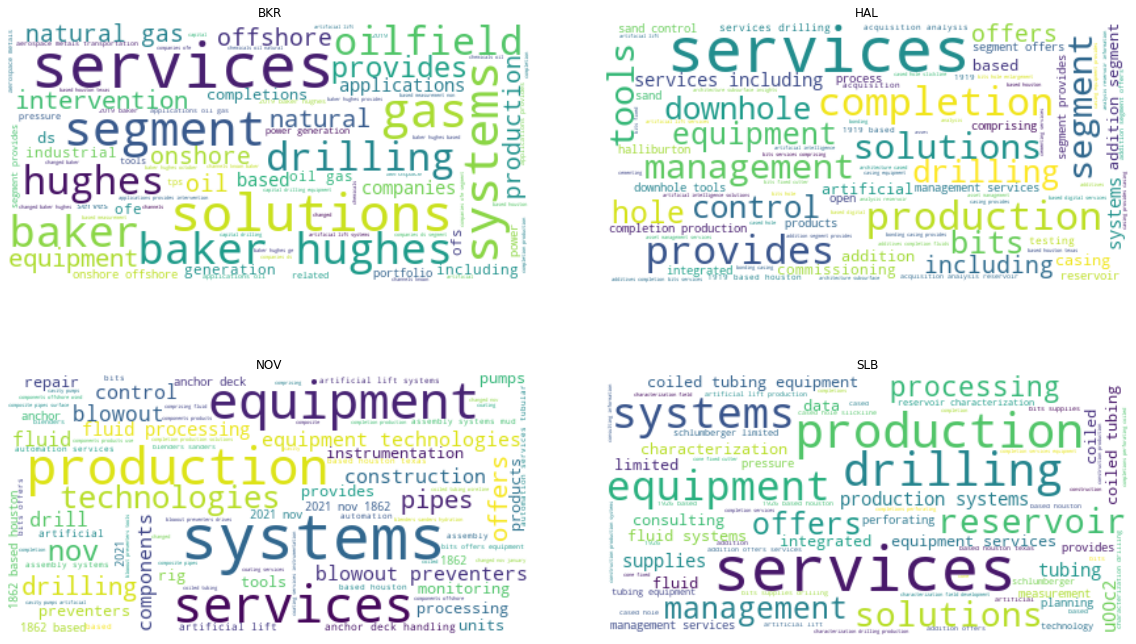

In [97]:
visualize_cluster(cluster)

## 6. Pairs Trading Analysis

### 6.a Historical Stock Prices

To examine how well our identified pairs trade algorithmically, we will first reload the historical stock prices.

In [98]:
stock_data = combined_stock_price_df
stock_data

MMM         ABT        ABBV        ABMD         ACN  \
2019-04-29  177.170822   75.875763   72.136856  274.000000  176.433182   
2019-04-30  176.518814   77.126305   71.319366  277.410004  177.854675   
2019-05-01  173.314636   76.331390   70.870193  277.070007  176.530518   
2019-05-02  172.085114   76.370163   70.492889  264.769989  174.661133   
2019-05-03  172.522873   76.282928   70.708488  271.750000  172.314682   
...                ...         ...         ...         ...         ...   
2021-04-22  200.899994  123.500000  110.050003  343.399994  290.160004   
2021-04-23  202.199997  123.309998  111.379997  351.029999  291.739990   
2021-04-26  199.630005  122.580002  111.389999  348.200012  289.519989   
2021-04-27  194.449997  121.699997  111.440002  340.630005  290.250000   
2021-04-28  195.929993  121.449997  111.930000  351.170013  290.269989   

                 ATVI        ADBE        AMD         AAP        AES  ...  \
2019-04-29  47.852070  286.140015  27.690001  165.076157  16.146397  ...   
2019-04-30  47.664215  289.250000  27.629999  164.630768  16.181368  ...   
2019-05-01  48.010258  283.350006  26.809999  162.166031  15.973430  ...   
2019-05-02  48.989048  279.640015  28.290001  165.086060  16.115202  ...   
2019-05-03  46.616219  285.579987  28.219999  161.611694  16.001785  ...   
...               ...         ...        ...         ...        ...  ...   
2021-04-22  93.699997  507.290009  79.059998  200.300003  28.320000  ...   
2021-04-23  93.019997  515.840027  82.760002  199.750000  28.299999  ...   
2021-04-26  94.239998  515.700012  85.410004  197.139999  28.209999  ...   
2021-04-27  91.599998  517.320007  85.209999  197.279999  27.799999  ...   
2021-04-28  91.250000  515.479980  84.019997  197.630005  27.969999  ...   

                  WLTW        WYNN        XEL        XLNX         XYL  \
2019-04-29  176.627579  143.701981  52.583630  114.096809   81.727402   
2019-04-30  179.371536  139.529129  53.579346  117.078827   81.317879   
2019-05-01  170.643311  141.161575  53.010361  113.668007   81.210625   
2019-05-02  173.688934  140.601318  53.029331  115.870430   77.554253   
2019-05-03  174.924728  142.340012  53.655212  115.987366   80.235596   
...                ...         ...        ...         ...         ...   
2021-04-22  233.149994  124.379997  71.120003  123.080002  109.080002   
2021-04-23  232.889999  124.150002  71.080002  129.660004  110.480003   
2021-04-26  231.300003  125.000000  70.599998  133.960007  110.440002   
2021-04-27  236.250000  127.750000  70.000000  133.610001  111.360001   
2021-04-28  245.880005  130.270004  69.809998  131.520004  111.260002   

                   YUM        ZBRA         ZBH       ZION         ZTS  
2019-04-29  100.136955  226.910004  119.042313  46.299034  100.104774  
2019-04-30  100.706123  211.139999  121.337830  46.214718  100.678154  
2019-05-01   98.342590  205.119995  119.426537  45.512085  100.628731  
2019-05-02   98.149635  205.940002  121.387100  46.355244  101.973213  
2019-05-03   99.095055  206.460007  122.470810  46.889248  102.566360  
...                ...         ...         ...        ...         ...  
2021-04-22  117.820000  487.350006  177.380005  52.560001  169.070007  
2021-04-23  117.720001  497.410004  177.619995  54.270000  170.539993  
2021-04-26  115.680000  498.500000  175.720001  54.610001  169.800003  
2021-04-27  116.410004  501.750000  176.350006  55.150002  169.750000  
2021-04-28  117.570000  496.600006  178.500000  55.250000  171.720001  

[505 rows x 505 columns]

Since `AOS` (A. O. Smith Corporation) and `PNR` (Pentair) were identified as being a good pairs trading candidate, we define them as `symbol_one` and `symbol_two` in our trading algorithm below:

In [99]:
symbol_one = 'AOS'
symbol_two = 'PNR'

In [100]:
stock_data = stock_data[[symbol_one,symbol_two]]
stock_data.index.name = 'Date'
stock_data

AOS        PNR
Date                            
2019-04-29  53.869961  37.541885
2019-04-30  50.742588  37.667469
2019-05-01  50.675022  37.522560
2019-05-02  50.694328  37.667469
2019-05-03  51.775387  38.140842
...               ...        ...
2021-04-22  67.750000  64.199997
2021-04-23  68.360001  64.309998
2021-04-26  67.900002  64.089996
2021-04-27  68.120003  64.080002
2021-04-28  66.540001  64.309998

[505 rows x 2 columns]

We focus on price data since January 1, 2020 in order to capture the coronavirus sell-off in March 2020 and subsequent stock market recovery.

In [101]:
stock1_name, stock2_name = symbol_one,symbol_two
orig_data = stock_data.loc['2020-01-01':,]
data = orig_data.diff().cumsum()
data1 = data[stock1_name].ffill().fillna(0).values
data2 = data[stock2_name].ffill().fillna(0).values

Let's now plot the historical stock prices for `AOS` and `PNR`.

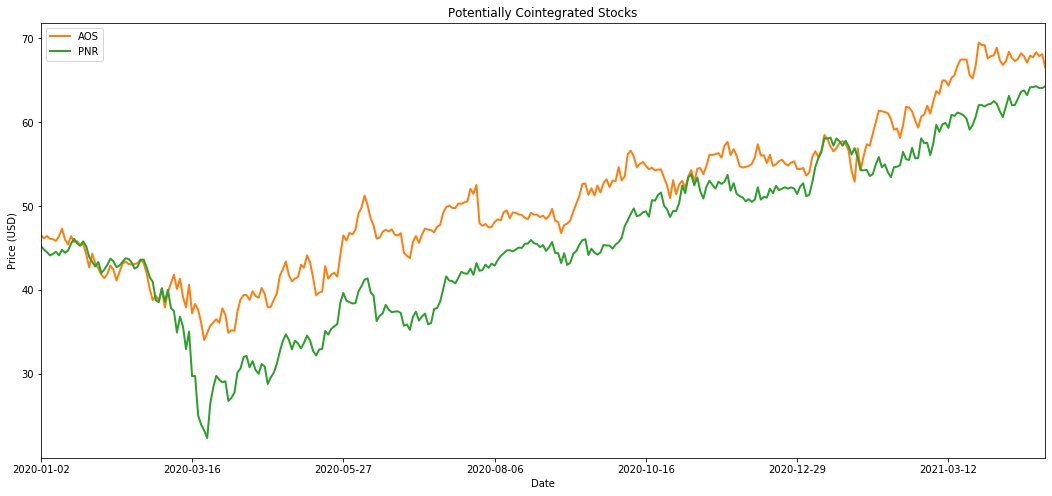

In [102]:
plt.figure(figsize = (18,8))
ax = plt.gca()
plt.title("Potentially Cointegrated Stocks")
orig_data[stock1_name].plot(ax=ax,color=sns.color_palette()[1],linewidth=2)
orig_data[stock2_name].plot(ax=ax,color=sns.color_palette()[2],linewidth=2)
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

These companies do indeed seem to have related price series.

### 6.b Bayesian Modeling

We take a Bayesian approach to pairs trading using probabilistic programming, which is a form of Bayesian machine learning. Unlike simpler frequentist cointegration tests, our Bayesian approach allows us to monitor the relationship between a pair of equities over time, which allows us to follow pairs whose cointegration parameters change steadily or abruptly. When combined with a simple mean-reversion trading algorithm, we demonstrate this to be a viable theoretical trading strategy, ready for further evaluation and risk management.

To learn more about this Bayesian approach to pairs trading, you can read AlphaWave Data's article titled [Bayesian Pairs Trading using Corporate Supply Chain Data](https://medium.com/@hdonnelly6/bayesian-pairs-trading-using-corporate-supply-chain-data-8b96305686d).

We will use a Bayesian probabilistic programming package called [PyMC3](https://docs.pymc.io/). Its simple syntax is excellent for prototyping as seen with the model description in the code below.

In [103]:
with pm.Model() as model:
    
    # inject external stock data
    stock1 = th.shared(data1)
    stock2 = th.shared(data2)
    
    # define our cointegration variables
    beta_sigma = pm.Exponential('beta_sigma', 50.)
    beta = pm.GaussianRandomWalk('beta', sd=beta_sigma,
                                 shape=data1.shape[0])
    
    # with our assumptions, cointegration can be reframed as a regression problem
    stock2_regression = beta * stock1

    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal('sd', sd=.1)
    likelihood = pm.Normal('y',
                           mu=stock2_regression,
                           sd=sd,
                           observed=stock2)

In [104]:
with model:
    stock1.set_value(data1)
    stock2.set_value(data2)
    trace = pm.sample(2000,tune=1000,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta, beta_sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.
The number of effective samples is smaller than 25% for some parameters.


Let's plot the $\beta$ distribution from the model over time.

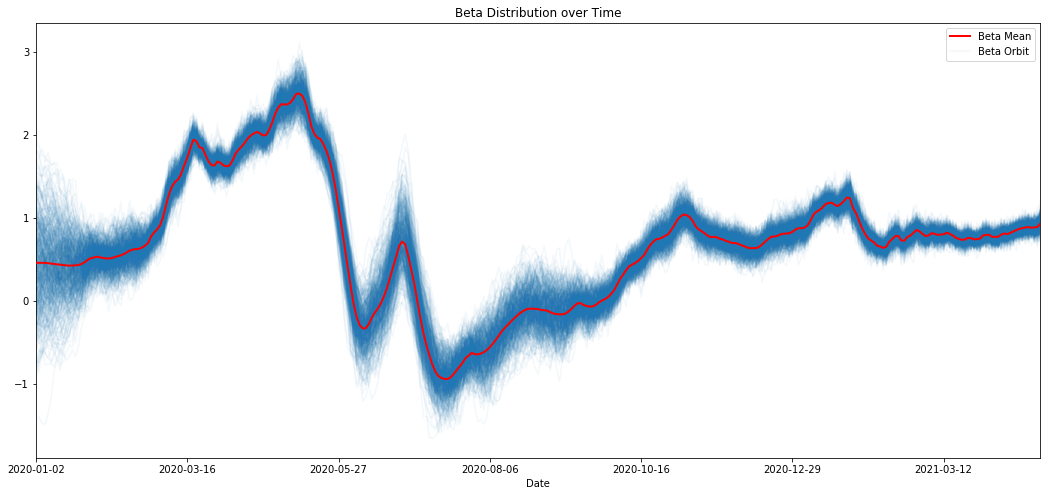

In [105]:
rolling_beta = trace[beta].T.mean(axis=1)

plt.figure(figsize = (18,8))
ax = plt.gca()
plt.title("Beta Distribution over Time")
pd.Series(rolling_beta,index=orig_data.index).plot(ax=ax,color='r',zorder=1e6,linewidth=2)
for orbit in trace[beta][:500]:
    pd.Series(orbit,index=orig_data.index).plot(ax=ax,color=sns.color_palette()[0],alpha=0.05)
plt.legend(['Beta Mean','Beta Orbit'])

plt.show()

Notice that $\beta$ appears to shift between somewhat fixed regimes, and often does so abruptly.

### 6.c Trading Strategy

Knowing that two stocks may or may not be cointegrated does not explicitly define a trading strategy. For that we present the following simple mean-reversion style trading algorithm, which capitalizes on the assumed mean-reverting behavior of a cointegrated portfolio of stocks. We trade whenever our portfolio is moving back toward its mean value. When the algorithm is not trading, we dynamically update $\beta$ and its other parameters, to adapt to potentially changing cointegration conditions. Once a trade begins, we are forced to trade the two stocks at a fixed rate, and so our $\beta$ becomes locked for the duration of the trade. The algorithm's exact implementation is as follows:

1. Define a "signal", which should mean-revert to zero if $\beta$ remains relatively stationary.
2. Define a "smoothed signal", a 15-day moving average of the "signal".
2. If we are not trading...
 * Update $\beta$ so that it does not remain fixed while we aren't trading.
 * If the smoothed signal is above zero _and_ moving downward, short our portfolio.
 * If the smoothed signal is below zero _and_ moving upward, go long on our portfolio.
3. If we are trading long...
 * If the smoothed signal goes below its start value, close the trade; we may be diverging from the mean.
 * If the smoothed signal rises through the zero line, we've reached the mean. Close the trade.
4. If we are trading short...
 * If the smoothed signal goes above its start value, close the trade; we may be diverging from the mean.
 * If the smoothed signal falls through the zero line, we've reached the mean. Close the trade.

In [106]:
def getStrategyPortfolioWeights(rolling_beta,stock_name1,stock_name2,data,smoothing_window=15):

    data1 = data[stock_name1].ffill().fillna(0).values
    data2 = data[stock_name2].ffill().fillna(0).values

    # initial signal rebalance
    fixed_beta = rolling_beta[smoothing_window]
    signal = fixed_beta*data1 - data2
    smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
    d_smoothed_signal = smoothed_signal.diff()
    trading = "not"
    trading_start = 0

    leverage = 0*data.copy()
    for i in range(smoothing_window,data1.shape[0]):
        leverage.iloc[i,:] = leverage.iloc[i-1,:]

        if trading=="not":

            # dynamically rebalance the signal when not trading
            fixed_beta = rolling_beta[i]
            signal = fixed_beta*data1 - data2
            smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
            d_smoothed_signal = smoothed_signal.diff()

            if smoothed_signal[i]>0 and d_smoothed_signal[i]<0:

                leverage.iloc[i,0] = -fixed_beta / (abs(fixed_beta)+1)
                leverage.iloc[i,1] = 1 / (abs(fixed_beta)+1)

                trading = "short"
                trading_start = smoothed_signal[i]

            elif smoothed_signal[i]<0 and d_smoothed_signal[i]>0:

                fixed_beta = rolling_beta[i]
                leverage.iloc[i,0] = fixed_beta / (abs(fixed_beta)+1)
                leverage.iloc[i,1] = -1 / (abs(fixed_beta)+1)

                trading = "long"
                trading_start = smoothed_signal[i]

            else:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0


        elif trading=="long":

            # a failed trade
            if smoothed_signal[i] < trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i]>0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

        elif trading=="short":

            # a failed trade
            if smoothed_signal[i] > trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i]<0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
    return leverage

### 6.d Backtesting & Performance in Market Drops

As a long-short algorithm, the expectation is that this algorithm would perform well during market drops. The backtest here includes the coronavirus sell-off in March 2020.

In [107]:
portfolioWeights = getStrategyPortfolioWeights(rolling_beta,stock1_name, stock2_name,data).fillna(0)

In [108]:
def backtest(pricingDF,leverageDF,start_cash):
    """Backtests pricing based on some given set of leverage. Leverage works such that it happens "overnight",
    so leverage for "today" is applied to yesterday's close price. This algo can handle NaNs in pricing data
    before a stock exists, but ffill() should be used for NaNs that occur after the stock has existed, even
    if that stock ceases to exist later."""
    
    pricing = pricingDF.values
    leverage = leverageDF.values
    
    shares = np.zeros_like(pricing)
    cash = np.zeros(pricing.shape[0])
    cash[0] = start_cash
    curr_price = np.zeros(pricing.shape[1])
    curr_price_div = np.zeros(pricing.shape[1])
    
    for t in range(1,pricing.shape[0]):
        
        if np.any(leverage[t]!=leverage[t-1]):

            # handle non-existent stock values
            curr_price[:] = pricing[t-1]     # you can multiply with this one
            curr_price[np.isnan(curr_price)] = 0
            trading_allowed = (curr_price!=0)
            curr_price_div[:] = curr_price    # you can divide with this one
            curr_price_div[~trading_allowed] = 1
            
            # determine new positions (warning: leverage to non-trading_allowed stocks is just lost)
            portfolio_value = (shares[t-1]*curr_price).sum()+cash[t-1]
            target_shares = trading_allowed * (portfolio_value*leverage[t]) // curr_price_div
            
            # rebalance
            shares[t] = target_shares
            cash[t] = cash[t-1] - ((shares[t]-shares[t-1])*curr_price).sum()
            
        else:
            
            # maintain positions
            shares[t] = shares[t-1]
            cash[t] = cash[t-1]
    
    returns = (shares*np.nan_to_num(pricing)).sum(axis=1)+cash
    pct_returns = (returns-start_cash)/start_cash
    return (
        pd.DataFrame( shares, index=pricingDF.index, columns=pricingDF.columns ),
        pd.Series( cash, index=pricingDF.index ),
        pd.Series( pct_returns, index=pricingDF.index)
    )

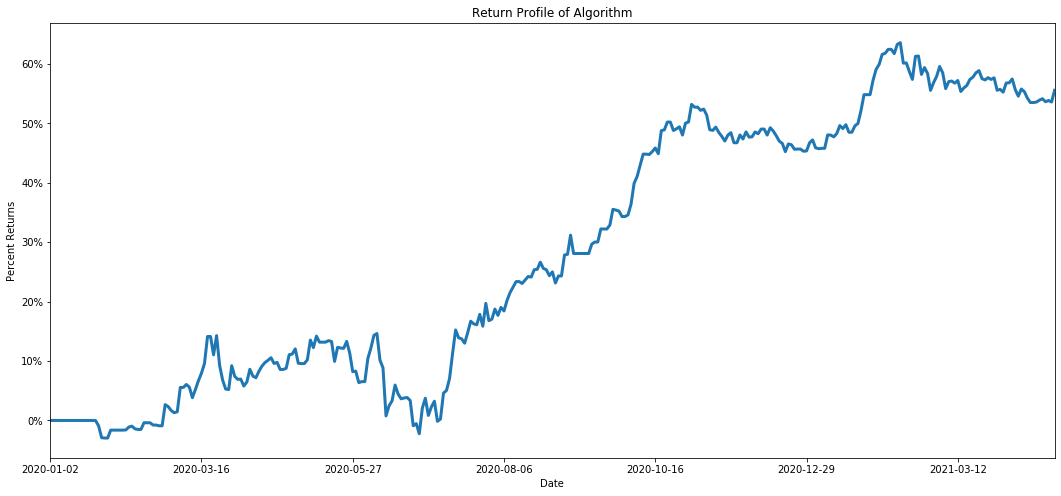

In [109]:
shares, cash, returns = backtest( orig_data, portfolioWeights, 1e6 )

plt.figure(figsize = (18,8))
ax = plt.gca()
plt.title("Return Profile of Algorithm")
plt.ylabel("Percent Returns")
returns.plot(ax=ax,linewidth=3)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.show()

As we might have hoped, performance through market drops is strong. Returns are somewhat outsized due to our portfolio only being two stocks. For a finalized version of this algorithm, we might trade a hundred pairs or more to reduce volatility.

## 7. Conclusions & Potential Future Directions

The search space to find valid pairs for a pairs trading strategy is vast. As researchers, we can add a lot of value by intelligently reducing this search space. "Machine Learning plus data" has a lot of value to add in this search. The majority of examples posted across the web for Machine Learning in finance attempt to predict future stock prices by training on past prices. This is unlikely to be successful out-of-sample as the signal-to-noise ratio in price data is very low and financial time series are non-stationary. Machine Learning though can help significantly to make an investment process smarter and faster and, as this example shows, uncover relationships embedded in unstructured data.

We also demonstrated a robust prototype for what would be built into a more sophisticated pairs trading algorithm. There are many places where this algorithm and approach could be improved, including expanding the portfolio, creating criteria for when $\beta$ is suitable to trade over, backtesting over more periods, using a Bayesian model with fewer simplifying assumptions, and investigating potential nonlinear relationships between stocks.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by AlphaWave Data, Inc. ("AlphaWave Data"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, AlphaWave Data, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to AlphaWave Data, Inc. at the time of publication. AlphaWave Data makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*